# Graphs in ML - TP1 : Spectral clustering
### Dimitri Bouche (dimitri.bouche@ensae.fr)

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
import scipy.spatial.distance as sd
import scipy.io as io
import sklearn.cluster as skc
import sys
import os

# Local imports
from helper import *
from graph_construction.generate_data import *

## 1. Graph construction

In [36]:
def similarity_matrix(X, var):
    # L2 distance matrix
    # IS IT THE SQUARE DISTANCE OR THE NORMAL DISTANCE
    dists = sd.squareform(sd.pdist(X))
    # Similarity matrix
    S = np.exp(-dists / var)
    return S

In [37]:
def build_epsilon_graph(X, var, eps):
    S = similarity_matrix(X, var)-np.eye(X.shape[0])
    S = np.maximum(S - eps, 0)
    return S

In [38]:
def build_knn_graph(X, var, k=5):
    # Remove the diagonal (self similarity)
    S = similarity_matrix(X, var)
    S_nodiag = S - np.eye(S.shape[0])
    wdir = np.zeros(S.shape)
    for i in range(0, S.shape[0]):
        neighbors_inds = np.argsort(-S_nodiag[i, :])[:k]
        wdir[i, neighbors_inds] = S[i, neighbors_inds]
    # The matrix is directed, we turn it into the at least k neighbors
    S = np.maximum(wdir, wdir.T)    
    return S

### Build similarity graph function

In [70]:
def build_similarity_graph(X, var, eps, k):
    assert eps + k != 0, "Choose either epsilon graph or k-nn graph"
    if eps != 0:
        return build_epsilon_graph(X, var, eps)
    else:
        return build_knn_graph(X, var, k)

### Plot similarity graph

In [40]:
def plot_similarity_graph(X, Y, var, eps, k):
    W = build_similarity_graph(X, var, eps, k)
    plot_graph_matrix(X,Y,W)   

In [61]:
# Parameters
n_samples = 10
gen_pam = 0.1
var = 0.3

In [62]:
# Generate data from worst_case_blob function
X, Y = worst_case_blob(n_samples, gen_pam)

### Epsilon graph

epsilon


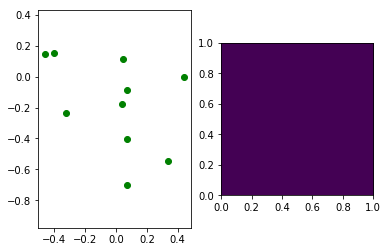

epsilon


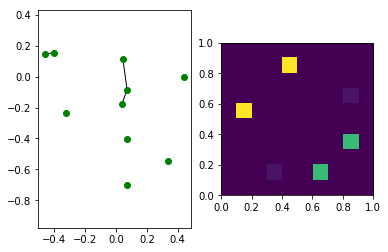

epsilon


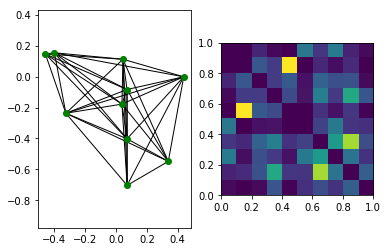

epsilon


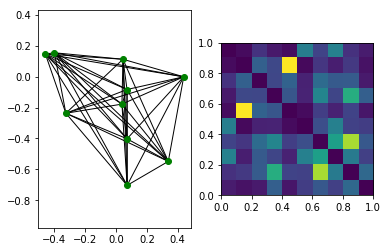

epsilon


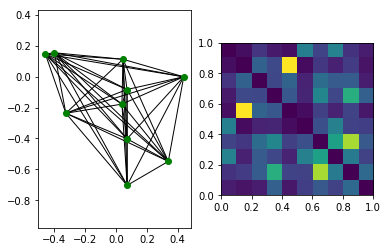

In [63]:
# Plot graph and similarity map for different values of epsilon 
epss = [1, 0.5, 0.05, 0.01, 0.005]
for eps in epss:
    plot_similarity_graph(X, Y, var, eps, 0)

In [64]:
def how_to_choose_epsilon(X, var, perturbation=0.0000001):
    S = similarity_matrix(X, var)
    max_tree = max_span_tree(S)
    a = max_tree * S
    epsilon =  np.min(a[a != 0])
    return epsilon - perturbation

### Pourquoi choisit-on $\epsilon$ comme ça ?
Le "maximum spanning tree" ou arbre couvrant est un graphe dont l'ensemble d'arrête est inclus dans celles du graphe original et qui relie tout les noeuds de celui-ci. Dès lors si l'on prend $\epsilon$ égale au poid sur l'arrête la plus faible de l'arbre couvrant on s'assure une parcimonie maximale ($\epsilon$ le plus grand possible) sans toutefois casser la connectivité. Néanmoins, si l'on prend $\epsilon$ exactement égal à ce poid minimal, on casse quand même l'arrête, il faut donc ajouter à cet $\epsilon$ optimal un légère perturbation strictement positive.

0.26436807907908577
epsilon


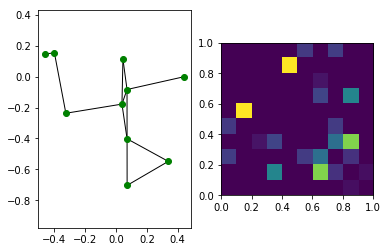

In [65]:
# How to chose epsilon test
eps_star = how_to_choose_epsilon(X, var)
print(eps_star)
W = build_similarity_graph(X, var, eps_star, 0)
plot_graph_matrix(X,Y,W)

On constate effectivement que le graphe est parcimonieux (peu de connections) mais connecté (même les points extrêmes). C'est ce que nous voulions.

### Neighbors graph

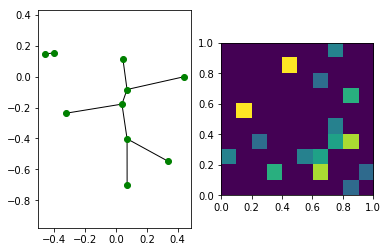

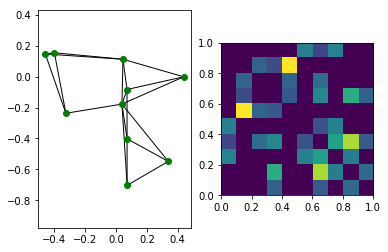

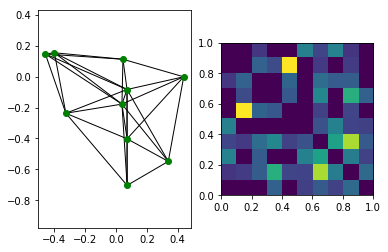

In [66]:
# Plot graph and similarity map for different number of neighbors
ks = [1, 3, 5]
for k in ks:
    plot_similarity_graph(X, Y, var, 0, k)

### 1.1 What is the purpose of the option parameter (gen_pam) in worst case blob ?
Ce paramètre a pour objectif d'ajouter un point "aberrant" au dataset (on ajoute un dernier point dont la première coordonnée est le maximum des coordonnées de tous les autres points auquel on ajoute en plus le paramètre **gen_pam** et la seconde coordonnée est 0. Dès lors plus **gen_pam** est grand, plus le point en question sera aberrant et donc difficile à connecter au reste (on devra forcément prendre un $\epsilon$ plus petit).

### 1.2 What happens when you change the generating parameter of worst_case_blob.m in how_to_choose_espilon.m and run the function? What if the parameter is very large?
Quand on change le paramètre **gen_pam**, comme justifié dans la précédente question, $\epsilon$ augmente. On le voit empiriquement dans les quelques testes ci-dessous. Quand **gen_pam** devient très grand, $\epsilon$ tend vers 0.

Text(0,0.5,'epsilon*')

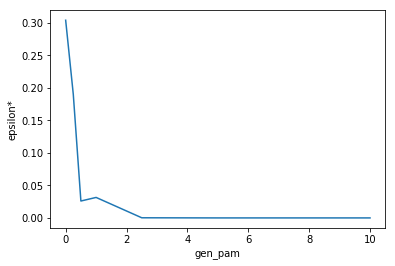

In [67]:
# Find epsilon optimal for several increasing values of gen_pams
gen_pams = [0, 0.25, 0.5, 1, 2.5, 5, 7.5, 10]
eps_stars = []
for gen_pam in gen_pams:
    X, Y = worst_case_blob(n_samples, gen_pam)
    eps_star = how_to_choose_epsilon(X, var)
    eps_stars.append(eps_star)
plt.plot(gen_pams, eps_stars)
plt.xlabel("gen_pam")
plt.ylabel("epsilon*")

### 1.3. Using plot_similarity_graph and one of the datasets, compare k-nn to ε graphs. When is it easier to build a connected graph using k-nn? When using ε graphs?

In [68]:
# Load the data 2blobs
data_blobs = io.loadmat(os.getcwd() + "/data/data_2blobs.mat")
X2blobs, Y2blobs = data_blobs["X"], data_blobs["Y"]

epsilon


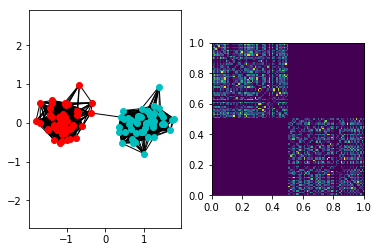

In [69]:
# Chose epsilon and plot the corresponding epsilon graph
eps_star = how_to_choose_epsilon(X2blobs, var)
plot_similarity_graph(X2blobs, Y2blobs, var, eps_star, 0)

Nous observons bien les deux aggrégats de points, le graphe reste toutefois connecté par un seul lien entre les deux aggrégats, ce qui montre que le choix de $\epsilon$ est pertinent.

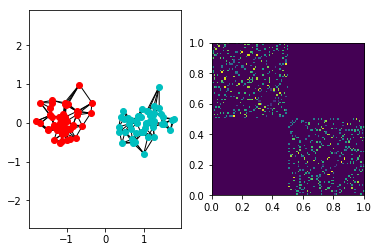

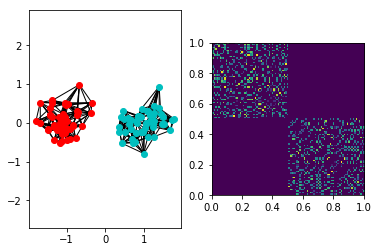

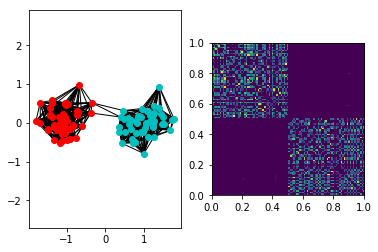

In [74]:
for k in [5, 10, 20]:
    plot_similarity_graph(X2blobs, Y2blobs, var, 0, k)   

Les deux méthodes permettent d'obtenir un des graphes à la fois connectés et parcimonieux dans leurs liens d'une composante à l'autre. Néanmoins pour epsilon, le choix du paramètre epsilon est assez lourd alors que pour les k plus proches voisins, essayé quelque valeurs selon des heuristiques prenant en compte le nombre de points de données nous fournit rapidement le graphe connecté que l'on cherche.

# 2. Spectral clustering

### build_laplacian function

In [94]:
def build_laplacian(W, laplacian_normalization=""):
#  laplacian_normalization:
#      string selecting which version of the laplacian matrix to construct
#      either 'unn'normalized, 'sym'metric normalization
#      or 'rw' random-walk normalization
    D = np.diag(W.sum(axis=0))
    L = D - W
    if laplacian_normalization=="sym":
        Dinv_sqrt = np.diag(1 / np.sqrt(np.diag(D)))
        return np.dot(np.dot(Dinv_sqrt, L), Dinv_sqrt)
    elif laplacian_normalization=="rw":
        Dinv = np.diag(1 / np.diag(D))
        return np.dot(Dinv, L)
    else:
        return L

### Spectral clustering function

In [120]:
def spectral_clustering(L, chosen_eig_indices, num_classes=2):
#  Input
#  L:
#      Graph Laplacian (standard or normalized)
#  chosen_eig_indices:
#      indices of eigenvectors to use for clustering
#  num_classes:
#      number of clusters to compute (defaults to 2)
#
#  Output
#  Y:
#      Cluster assignments


    #################################################################
    # compute eigenvectors                                          #
    # U = (n x n) eigenvector matrix                                #
    # E = (n x n) eigenvalue diagonal matrix (sorted)               #
    #################################################################

    E, U = np.linalg.eig(L)
    order = np.argsort(E)
    E, U = np.diag(E[order]), U[:, order]

    #################################################################
    #################################################################

    #################################################################
    # compute the clustering assignment from the eigenvector        #
    # Y = (n x 1) cluster assignments [1,2,...,c]                   #
    #################################################################
    
    kmeans_clustering = skc.KMeans(n_clusters=num_classes)
    kmeans_clustering.fit(U[:, chosen_eig_indices])

    Y = kmeans_clustering.predict(U[:, chosen_eig_indices])
    
    #################################################################
    #################################################################
    return Y


### Two blobs clustering

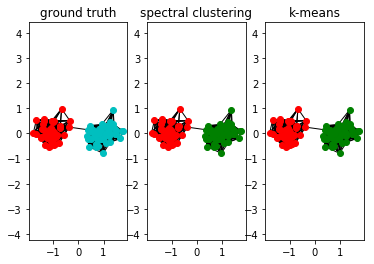

In [126]:
# Load the data 2blobs
data_blobs = io.loadmat(os.getcwd() + "/data/data_2blobs.mat")
X2blobs, Y2blobs = data_blobs["X"], data_blobs["Y"]

# automatically infer number of labels from samples
num_classes = len(np.unique(Y2blobs))

# exponential_euclidean's sigma^2
var = 0.3

# Laplacian normalization choice
laplacian_normalization = 'unn'

# indices of the ordered eigenvalues to pick
chosen_eig_indices = [1]

# Build graph
epsilon = how_to_choose_epsilon(X2blobs, var)
W2blobs = build_epsilon_graph(X2blobs, var, epsilon)

# Build Laplacian
L2blobs = build_laplacian(W2blobs, laplacian_normalization)

# Perform spectral clustering
Y_rec = spectral_clustering(L2blobs, chosen_eig_indices, num_classes=2)

# Plot clustering results (compare to ground truth and kmeans)
plot_clustering_result(X2blobs, Y2blobs, L2blobs, Y_rec,skc.KMeans(num_classes).fit_predict(X2blobs))

### Question 2.1
- Dans le cas où nous avons $k=2$ clusters, le problème de ratio cut peut s'exprimer de manière équivalente comme un problème de minimisation de forme quadratique définie par le Laplacien: $f^T L f$ sous contrainte que $f$ soit orthogonal au vecteur $\mathbf{1}$ et que toutes les composantes de $f$ soient des 1 ou des -1. Ce problème étant NP-hard on fait une relaxation en autorisant $f\in \mathbb{R}$ et en imposant $||f|| = \sqrt(n)$. La condition d'orthogonalité vient du fait que le vecteur $\mathbf{1}$ est le premier vecteur propre du spectre (associé à la plus petite valeur propre) du Laplacien **quelque soit le graphe** et il ne contient en conséquence pas d'information sur celui-ci. La solution au problème relaxé est par le théorème de Rayleigh-Ritz le second vecteur propre (associé à la seconde plus petite valeur propre) du Laplacien. Néanmoins, pour en tirer une solution au problème discret il faut une règle pour transformer celui-ci en vecteur de 1 et -1 définissant l'appartenance à un cluster ou à un autre. Pour ce faire, en pratique, nous utilisons un algorithme de clustering avec k=2 sur ses coordonnées. Kmeans fait par exemple l'affaire.

- Dans le cas $k>2$, un raisonnement du même type conduit à choisir les $k$ vecteurs propres associés aux $k$ valeurs propre les plus petites **en partant du second vecteur propre, le premier étant toujours $\mathbf{1}$**. On forme la matrice $V$ dont les colonnes sont ces vecteurs propres. Pour revenir à un problème discret on applique un algorithme de clustering aux lignes de $V$ pour $k$ clusters. Le cluster de la première ligne nous donne le cluster du premier point de données, le cluster de la seconde ligne celui du second et ainsi de suite.

### Question 2.2

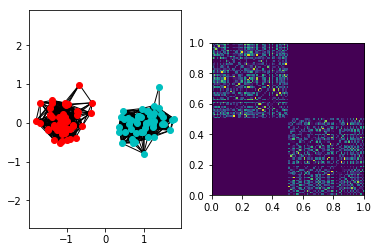

In [122]:
# Find epsilon such that the graph is disconnected
eps = 0.1
plot_similarity_graph(X2blobs, Y2blobs, var, eps, 0)

# Build disconnected graph
W2blobs = build_epsilon_graph(X2blobs, var, eps)

# Build Laplacian
L2blobs = build_laplacian(W2blobs, laplacian_normalization)

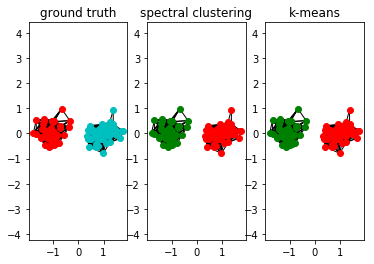

In [124]:
# indices of the ordered eigenvalues to pick
chosen_eig_indices = [1]
Y_rec = spectral_clustering(L2blobs, chosen_eig_indices, num_classes=2)

# Plot clustering results (compare to ground truth and kmeans)
plot_clustering_result(X2blobs, Y2blobs, L2blobs, Y_rec,skc.KMeans(num_classes).fit_predict(X2blobs))

### Question 2.2 (justification)
Dans ce cas également nous choisissons le vecteur propre associé à la seconde plus petit valeur propre. C'est le cas "idéal" que l'on essaie d'approcher avec le ratio cut, le graphe a deux composantes déconnectées, nous n'avons en conséquence pas de raisons de changer notre choix de vecteur propre. Nous pourrions nous demander pourquoi dans ce cas là ne pas choisir $\epsilon$ de manière à avoir toujours un graphe n'ayant pas de connections entre les clusters ? Le problème est que nous ne connaissons pas toujours à priori le nombre de clusters, dès lors comment choisir $\epsilon$ qui deconnectent les différents clusters en gardant les connections intra clusters: nous ne pouvons pas toujours visualiser comme ici.

### Question 2.3

In [187]:
def choose_eig_function(eigenvalues):
    #  [eig_ind] = choose_eig_function(eigenvalues)
    #     chooses indices of eigenvalues to use in clustering
    #
    # Input
    # eigenvalues:
    #     eigenvalues sorted in ascending order
    #
    # Output
    # eig_ind:
    #     the indices of the eigenvectors chosen for the clustering
    #     e.g. [1,2,3,5] selects 1st, 2nd, 3rd, and 5th smallest eigenvalues

    # discrete variation of eigen values
    diffs = np.diff(eigenvalues)
    # Average of discrete variation
    avg_diff = np.mean(diffs)
    # We select up to the first strictly above average eigen value variation
    selected = np.argwhere(diffs > avg_diff)[0][0]
    eig_ind = list(range(1, selected + 1))
    #################################################################
    #################################################################
    
    return eig_ind

### Explication de la selection automatique
La règle de pouce consiste à chercher une rupture dans les valeurs propres (qui n'existe pas forcément d'ailleurs). Une heuristique simple pour chercher cette rupture est de calculer les variations des valeurs propres, de calculer la moyenne de ces variations et de s'arrêter la première fois que l'on a une variation supérieure strictement à la moyenne des variations.

In [188]:
def spectral_clustering_adaptive(L, num_classes=2):
    #      a skeleton function to perform spectral clustering, needs to be completed
    #
    #  Input
    #  L:
    #      Graph Laplacian (standard or normalized)
    #  num_classes:
    #      number of clusters to compute (defaults to 2)
    #
    #  Output
    #  Y:
    #      Cluster assignments

    #################################################################
    #################################################################


    #################################################################
    # compute eigenvectors                                      #####
    # U = (n x n) eigenvector matrix                            #####
    # E = (n x n) eigenvalue diagonal matrix (sorted)           #####
    #################################################################

    E, U = np.linalg.eig(L)
    order = np.argsort(E)
    E, U = np.diag(E[order]), U[:, order]
    eigenvalues = np.diag(E)[:15]
    
    chosen_eig_indices = choose_eig_function(eigenvalues)

    #################################################################
    #################################################################


    #################################################################
    # compute the clustering assignment from the eigenvector    #####
    # Y = (n x 1) cluster assignments [1,2,...,c]               #####
    #################################################################

    kmeans_clustering = skc.KMeans(n_clusters=num_classes)
    kmeans_clustering.fit(U[:, chosen_eig_indices])
    

    Y = kmeans_clustering.predict(U[:, chosen_eig_indices])

    #################################################################
    #################################################################
    return Y

### Find the bend

In [236]:
def find_the_bend(sigma, epsilon):

    # the number of samples to generate
    num_samples = 600

    # Load data
    [X, Y] = blobs(num_samples,4,sigma)

    # Automatically infer number of clusters from samples
    num_classes = len(np.unique(Y));

    # Experiment parameters
    var = 0.3 # exponential_euclidean's sigma^2
    laplacian_normalization = 'unn'; #either 'unn'normalized, 'sym'metric normalization or 'rw' random-walk normalization

    # Build graph and plot it
    W = build_epsilon_graph(X, var, epsilon)
    
    # Build Laplacian
    L = build_laplacian(W, laplacian_normalization)

    # Compute first 15 eigenvalues and sort them                       
    E, U = np.linalg.eig(L)
    order = np.argsort(E)
    E, U = E[order], U[:, order]
    eigenvalues = E[:15]

    # Choice of eigen values using choose_eig_function
    chosen_eig_indices = choose_eig_function(eigenvalues) # indices of the ordered eigenvalues to pick
    print("Automatic choice of eigenvalues: " + str(chosen_eig_indices))

    # Plot the eigen values
    plt.plot(eigenvalues)
    plt.ylabel("Eigenvalue")
    
    ################################################################
    # compute spectral clustering solution using a non-adaptive     #
    # method first, and an adaptive one after (see handout)         #
    # Y_rec = (n x 1) cluster assignments [1,2,...,c]               #
    #################################################################

    # Non adaptive
    Y_rec_nonadapt = spectral_clustering(L, chosen_eig_indices=[1, 2, 3, 4], num_classes=4)
    
    # Adaptive
    Y_rec_adapt = spectral_clustering_adaptive(L, num_classes=4)

    #################################################################
    #################################################################

    # Plot the result for the adaptative version
    plot_the_bend(X, Y, L, Y_rec_adapt, eigenvalues)

#### Test avec $\sigma^2 =0.03$

Automatic choice of eigenvalues: [1, 2, 3]


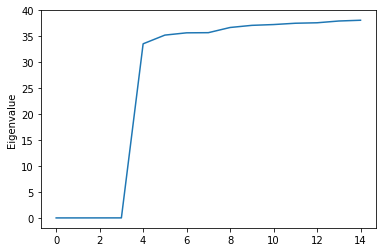

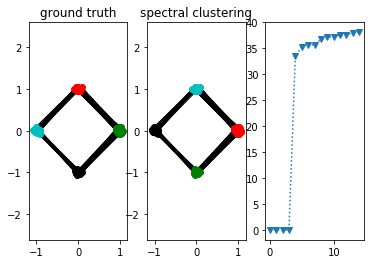

In [240]:
find_the_bend(sigma=0.03, epsilon=0.012)

Nous observons que pour cette valeur de $\sigma^2$, le saut dans les valeurs propres est très net. Notre méthode de sélection automatique est pertinente puisque nous trouvons exactement les indexes des valeurs propres qui sont avant la rupture (en enlevant la première donc l'indice 0).

### Question 2.4: Test avec $\sigma^2 =0.2$

Automatic choice of eigenvalues: [1, 2, 3]


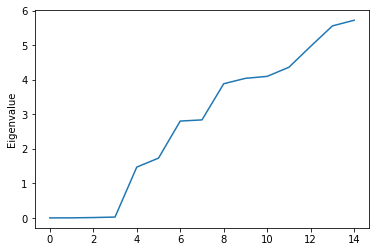

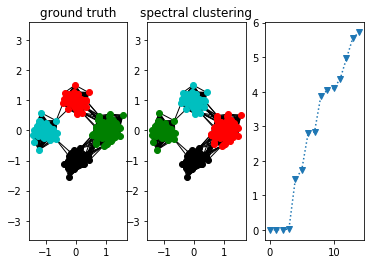

In [241]:
find_the_bend(sigma=0.2, epsilon=0.1)

Nous observons ici que le saut est beaucoup moins net que dans le cas précédent, bien qu'il soit toujours existant et que notre fonction de sélection automatique ait quand même réussi à trouver la rupture.

### Question 2.5
Nous avons utilisé kmeans pour  assigner les points aux clusters. 

### Question 2.6
Regarder l'évolution des valeurs propres peut aussi nous aider à savoir si les clusters sont proches les uns des autres. Autrement dit, plus la croissance des valeurs propres est progressive, plus les clusters sont proches/se chevauchent (et donc plus le problème est compliqué).

### Question 2.7

In [ ]:
def two_moons_clustering():
    #       a skeleton function for questions 2.7

    # load the data

    in_data =scipy.io.loadmat(path+'/data/data_2moons')
    X = in_data['X']
    Y = in_data['Y']

    # automatically infer number of labels from samples
    num_classes = len(np.unique(Y))

    #################################################################
    # choose the experiment parameter                               #
    #################################################################

    k=
    var = ; # exponential_euclidean's sigma^2

    laplacian_normalization = ; #either 'unn'normalized, 'sym'metric normalization or 'rw' random-walk normalization
    chosen_eig_indices =  # indices of the ordered eigenvalues to pick

    #################################################################
    #################################################################

    # build laplacian
    W=
    L = 

    Y_rec = 

    plot_clustering_result(X, Y, L, Y_rec,skc.KMeans(num_classes).fit_predict(X))
